![DLI Logo](../assets/DLI_Header.png)

In [1]:
%%html
<video controls src="https://d36m44n9vdbmda.cloudfront.net/assets/s-ds-03-v1/videos/evasion.mp4" 
width=800>evasion</video>

# Introduction

In this module, you will learn how about model **evasion**.

_model evasion_: Generating a sample to intentionally get misclassified while preserving some other property (such as human imperceptibility). 

## Learning Objectives:

1. Understand the concept of evasion with random perturbations.
2. Apply more nuanced attacks to understand efficiency and tradecraft.
3. Understand the differences between _targeted_ and _untargeted_ evasion.
4. Optimize attacks.

```{tip} Table of Contents
For easier navigation, select _Table of Contents_ from the _View_ menu.
```

# Evasion

In this lesson, we will cover the following topics.

First, we'll introduce some terminology, including what an adversarial evasion is, different levels of model access, and different variations on the goal of the attack. We'll load up some boilerplate code, and briefly analyze our target image with the MobileNet_V2 model, which we'll be attacking.

Next, we will explore a naive approach to adversarial sample generation, and then show you how to develop an _untargeted_ adversarial evasion by hand using the Carlini and Wagner L2 method (you can read the academic paper that introduced it [here](https://arxiv.org/abs/1608.04644) if you're interested). This will make a photo of a dog look like something (anything) other than a dog, and do a brief analysis of what changed in the image to make it adversarial.

After that, we'll turn our attention to _targeted_ adversarial examples: we'll adjust the technique to make the same photo of a dog be misclassified as a _specific_ other class, in this case a corskscrew.

## Introduction

One of the first attacks developed against machine learning models were evasion attacks. This is an attack in which an attacker perturbs an input such that a model produces an incorrect output (for example: this photo of a dog is now classified as a corkscrew), but some useful property of the input is not changed (e.g., it still looks like a dog to a person). Most of these attacks are against image classifiers, however we'll look at evading text classifiers in later labs. The process for evading a model is the same across pretty much all modalities -   

- Content filters: the "useful property" we're preserving is that the phishing email ends up in the target inbox, while the machine learning system being evaded is a spam filter. 
- Facial Recognition: You wear a mask that obfuscates your face
- Sentiment classifiers: It looks like a positive review to a human, but a scathing condemnation to the model.
- Malware detector: The ML model labels a malicious file as benign despite it executing the same malicious functionality.

In all cases, the core idea is to find some perturbation which will move the input across a decision boundary, which you can recognize as an "objective function". Which specific technique you use will largely depend on the operational constraints of your target, particularly what kind of data you're working with, and what kind of access you have to the model. When gearing up for an attack, you should first figure out the modality of the model (which should be fairly obvious), but strictly speaking, it is not a requirement. Next, you should decide what kind of model access you have, as this will also affect the technique or attacks available to use. 

This lab is going to feel long, and everything will eventually all mush together in your brain. We're going to run a few different attacks and adjust our assumptions each time to reflect the various types of model access will get. Here's a helpful guide where we define some attacks based on the amount of access required (how much data do you have about model internals) and whether the attack is targeted (are you trying to force the classification to a specific class):

| Attack | Access | Targeted | 
| -- | -- | -- |
| Random | Any | No |
| Carlini L2 | Gradients (Open box attack) | Both | 
| SimBA | Proabilities (Partial knowledge attack) | Both | 
| HopSkipJump | Single label (Closed box attack) | No (bc time) | 


When you're attacking models, access typically comes in one of three flavors:

- **Gradient Access** (or "Open box" attack): You have complete access to the model, either by stealing it, or by the victim using a pretrained model that you have identified and found your own copy of on say, HuggingFace. In this case, you can use open-box gradient-based attacks. These attacks use the weights (parameters of the model).
- **Scores** (or "gray-box" attack): You have API access to the model which provides complete numerical outputs of the model. In this case, you can use methods that estimate the gradients from the scores, `{"class_0: "0.89, class_1: 0.06, class_2: 0.049, class_3: 0.01}`. These attacks use "soft" labels, or probabilities from the output.
- **Labels** (or "closed-box" attack): You have API access to the model that only returns the label of the input (or, occasionally, the top 5 or so labels). In this case, you are often forced to use noisier techniques that estimate gradients based on sampling. `[class_0, class_1, class_2, class_3]`. These are "hard" labels, and represent the represent the most difficult targets, with `[class_0, class_1]` theoretically being the most difficult. Some algorithms (like HopSkipJump) can use any access.

**NOTE:** This course is very interactive and sometimes progress is hard to communicate accurately with progress bars. Trust the process and let the machine go "brrrrr".

Let's begin.

### Imports and Model Loading
First, we'll import the required libraries and load our model. We also set the device in order to ensure we use the GPU if it's available. 

In [1]:
# DO NOT CHANGE

import torch
from PIL import Image
from IPython import display

import pandas as pd
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

C:\Users\Usuario\Anaconda3\envs\llama\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


We're using `MobileNetV2` as a victim model to evade. It's a convolutional neural network that can classify up to 1000 objects (the ImageNet categories): animals, hats, cars, etc. It's not State-of-the-Art (SOTA) and we're using it for exactly this reason. While this model is not SOTA, it's still an _extremely_ capable model. There is a lot of hype in this space, but to be a well-rounded "AI Red Teamer", it's important you remain grounded in field as a whole. 

In [2]:
# DO NOT CHANGE

#load the model from the pytorch hub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.DEFAULT', verbose=False)

# Put model in evaluation mode
model.eval()

# put the model on a GPU if available, otherwise CPU
model.to(device);

Remember to place the model into `eval` mode -- this will ensure layers that change behavior during training (like `batchnorm` or `dropout`) aren't accidentally active or updating during inference -- and to move the model to the correct device.

Image data, by default, is usually read as values from `0-255` for each channel.  Because neural networks are more robust when the inputs are relatively small, and centered around zero, we apply the `preprocessing` function below that uses statistics from the training data to re-scale the data so that it's in zero-centered and in a smaller range. The implication is that once you train a model on data that has been transformed like this, you have to do the same transformation for _all_ data that you push through the model in order to get the correct results.

When attacking APIs, you will typically not need to preprocess the image manually, the model service will usually perform the preprocessing as part of the inference process.  

In [3]:
# DO NOT CHANGE

# Define the transforms for preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256
    transforms.CenterCrop(224),  # Crop the image to 224x224 about the center
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize the image with the ImageNet dataset mean values
        std=[0.229, 0.224, 0.225]  # Normalize the image with the ImageNet dataset standard deviation values
    )
]);

The second function is `unnormalize` - this function takes an input image tensor that has been preprocessed for our model and reverses the preprocessing steps to return the original image such that we can view, save, and look at it with our human eyes. This you will often have to implement yourself.

The reason is looks like it does, is because `torch` [doesn't have](https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821) an `UnNormalize` function. Fortunately, we can still recover our original image by reversing the normalization operation performed during preprocessing. 

In [4]:
# DO NOT CHANGE

unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
   std= [1/s for s in [0.229, 0.224, 0.225]]
)

We will also define a function that will assist in visualizing tensor images, to avoid some unnecessary copy pasta.

In [5]:
def tensor_to_pil(img_tensor):
    # tensor: pre-processed tensor object resulting from preprocess(img).unsqueeze(0)
    unnormed_tensor = unnormalize(img_tensor)
    return transforms.functional.to_pil_image(unnormed_tensor[0])

Finally, we load the labels that match output index to the class of the output.

In [6]:
# DO NOT CHANGE

# load labels
with open("data/labels.txt", 'r') as f:
    labels = [label.strip() for label in f.readlines()]

Models require numbers in and give numbers back. You use these labels (one per line) to recover the human-readable output. If you get them wrong, you _will_ introduce bugs in downstream systems. We hesitate to say it's a bug of the model, as the model does numbers in, numbers out, but it can be a big deal if implemented incorrectly. 

Next, we'll load an image we got off the Internet and run it through the `preprocess` pipeline. 

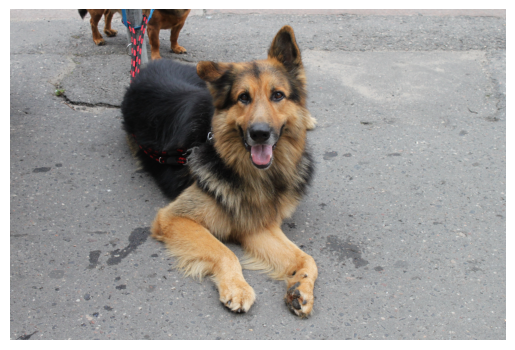

In [7]:
# DO NOT CHANGE

# load an example image
img = Image.open("data/dog.jpg")

plt.imshow(img)
plt.axis('off')
plt.show()

Our base image is a German Shepherd. It's _always_ a good idea to look at your data. Next, we'll run the preprocessing.

Recall that most vision models require a batch index, so we use the `unsqueeze` function to add one. 

In [8]:
# DO NOT CHANGE

# preprocess the image
img_tensor = preprocess(img).unsqueeze(0)

print(f"Inputs information:\n---------------\nshape:{img_tensor.shape}\n")

Inputs information:
---------------
shape:torch.Size([1, 3, 224, 224])



Finally, we can use the model. Here we move the sample to the correct device (the `GPU`) before running inference and printing some info. We split the code cells just to make it more readable.

In [9]:
# DO NOT CHANGE

# move sample to the right device
img_tensor = img_tensor.to(device)

with torch.no_grad():
    output = model(img_tensor)

In [10]:
# DO NOT CHANGE

print(f"Image tensor on device:\n---------------\n{img_tensor.device}\n")
print(f"Inputs information:\n---------------\nshape:{img_tensor.shape}\nclass: {type(img_tensor)}\n")
print(f"Shape of outputs:\n---------------\n{output.shape}\n")
print(f"Pred Index:\n---------------\n{output[0].argmax()}\n")
print(f"Pred Label:\n---------------\n{labels[output[0].argmax()]}\n")

Image tensor on device:
---------------
cuda:0

Inputs information:
---------------
shape:torch.Size([1, 3, 224, 224])
class: <class 'torch.Tensor'>

Shape of outputs:
---------------
torch.Size([1, 1000])

Pred Index:
---------------
235

Pred Label:
---------------
German shepherd



We can take the preprocessed image and convert it back to a standard image format. Note that it's been cropped, and the resizing operation has left it slightly smaller.

In [11]:
# DO NOT CHANGE

img_pil = tensor_to_pil(img_tensor)
img_pil.show()

###  "Evasion" With Random Noise

:::{exercise}

For fun, let's try to get a German Shepard randomly. Write a loop that,

1. Generates a random tensor and send it to the model for inference -- try modifying the rescaling of the random noise below (the `*1`, and `+0` bits)
2. Store the output index, output label, and image in a tuple 
3. Add that tuple to a list
4. Stop when you get output index of `235` **OR have run `1000` queries**
5. Look at a few of the images

```python
queries = 1000
target_output = 235
tensor = torch.randn(3, 224, 224) * 1.0 + 0.0
```

Success criteria for this exercise **do not** require you to actually create a sample of random noise that gets classified as a German Shepherd: that's extremely unlikely (but let us know if it happens!) -- just to try to do it.  Please stop at 1000 attempts.

What we expect you to get from this exercise:
1. Even though the images you have generated at random look like noise, the model still classifies them confidently (why?).
2. Random search is not an efficient way of generating adversarial samples.

:::

In [13]:
# your code here
queries = 1000
target_output = 235
i = 0
output_index = 1000
max_val = torch.max(img_tensor)
min_val = torch.min(img_tensor)
modifier = max_val-min_val
while not output_index == target_output:
    tensor = torch.randn(3, 224, 224).to(device) * modifier + modifier
    tensor = tensor.unsqueeze(0).to(device)
    output = model(tensor)
    output_index = output[0].argmax()
    output_label = labels[output_index]
    i+=1
    if i%100==1:
        print(output_index,output_label)
    if i == queries:
        break
print(output_index,output_label)# print every 100th

tensor(78, device='cuda:0') tick
tensor(21, device='cuda:0') kite
tensor(21, device='cuda:0') kite
tensor(21, device='cuda:0') kite
tensor(21, device='cuda:0') kite
tensor(21, device='cuda:0') kite
tensor(21, device='cuda:0') kite
tensor(21, device='cuda:0') kite
tensor(78, device='cuda:0') tick
tensor(78, device='cuda:0') tick
tensor(21, device='cuda:0') kite


The solution can be found in the [answer key](answers-1_evasion-open-box.ipynb) notebook if you need it.

With any luck you were successful, and if you were successful it was indeed pure luck. However, a lot of attacks start this way, and random guessing like this is a valid strategy. It's maybe even concerning that models even behave like this. However, we're not here to guess randomly, there are many algorithms we can use to help us get to where we want to go. Consider guess-and-check as your worst-case scenario. 

## Implementing the (Open-Box) Carlini and Wagner L2 Attack by Hand

Let's move on to our first attack. We'll implement the [Carlini L2](https://github.com/carlini/nn_robust_attacks/blob/master/l2_attack.py) attack. This attack is named after Nicholas Carlini, a Researcher at Google Brain (his name will come up a lot in this space). 

The key insight to this (and other attacks in this space) is that rather than optimizing the model weights, we can optimize the _input image_.  If we use optimization tools to simultaneously...
1. Modify the input image so that the classification loss is either _maximized_ with respect to the correct label, or _minimized_ with respect to a different label, and
2. Minimize the difference between the evasive image and the original image

...then we can develop an image that is misclassified by the model (because we increased the loss) but is not too dissimilar from the original image (because we minimized the difference between them). All of the tools we use to optimize models when training them are at our disposal, we're just changing the target. 

### Untargeted Carlini and Wagner Attack

Because our main success criteria is that our photo of a German Shepherd gets classified as _anything_ as long as it's not a German Shepherd, this is an _untargeted attack_.

To implement this algorithm we will,

1. Generate a `mask` as a parameter that we will add to the image; we'll initialize it using very small samples from a normal distribution
2. Make an optimizer for the `mask`
3. Compute the loss as the *negative* of the normal classification loss (so it makes the loss for the image higher, i.e. less likely to be correct) combined with the sum of squared values of the individual pixels in the mask aka the "L2 Norm"
4. Finally, we let the optimizer work its magic, and try to maximize the chance of misclassification by the model, while keeping the `mask` (perturbation) small

**Again:** the key insight here is that the `mask` can be optimized while we hold the model weights constant, and by optimizing towards the right target, we can control the classification and appearance of the adversarial image.

#### Generate the Mask
A mask is exactly as it sounds. It is simply another array overlayed on top of the orginal image. Here we reload our `img_tensor` to make sure we're not using an old version, generate a random `mask` to add to the `img_tensor`, then we make the image `img_tensor + mask_parameter` -- this is what gets submitted to the model. The difference between our malicious image and the originial image is then simply the mask parameter.

In [11]:
# DO NOT CHANGE

# define how much we want to change the image 
change = 1e-3

# create new img_tensor
img_tensor = preprocess(img).unsqueeze(0)

# create the halloween mask 
mask = torch.randn_like(img_tensor)*change

In [12]:
print(mask.shape)
# turn in into something torch can work with
mask_parameter = torch.nn.Parameter(mask)
print(mask_parameter.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [13]:
# create the final dog + noise
masked_img_tensor = img_tensor + mask_parameter

print(f"Mask shape:\n---------------\n{mask.shape}\n")

Mask shape:
---------------
torch.Size([1, 3, 224, 224])



When we look at the samples side-by-side, despite looking the same and being predicted as the same, they are ever so slightly different.

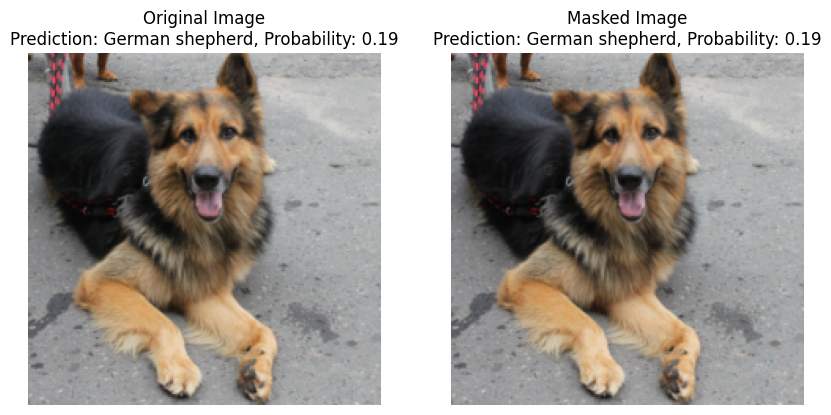

In [14]:
# DO NOT CHANGE

# get the model prediction for the original image and the masked image
# move sample to the right device

img_tensor = img_tensor.to(device)
masked_img_tensor = masked_img_tensor.to(device)

with torch.no_grad():
    output = model(img_tensor)
    masked = model(masked_img_tensor)
    
    probs = torch.softmax(output, dim=1)[0][output[0].argmax()].item()
    mask_probs = torch.softmax(masked, dim=1)[0][masked[0].argmax()].item()

    prediction = labels[output[0].argmax()]
    mask_prediction = labels[masked[0].argmax()]

    img_pil = tensor_to_pil(img_tensor)
    masked_pil = tensor_to_pil(masked_img_tensor)
    
plt.figure(figsize=(10, 5))  # Adjust the figsize as needed
plt.subplot(1, 2, 1)
plt.imshow(img_pil)
plt.title(f"Original Image\nPrediction: {prediction}, Probability: {probs:.2f}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_pil)
plt.title(f"Masked Image\nPrediction: {mask_prediction}, Probability: {mask_probs:.2f}")
plt.axis('off')

plt.show()

Here we show you the distance between the two images.

In [15]:
# DO NOT CHANGE

l2_norm = torch.norm(img_tensor - masked_img_tensor, p=2)
print("Distance (L2 norm) between original image and masked image:\n---------------\n", l2_norm.item())

Distance (L2 norm) between original image and masked image:
---------------
 0.3895855247974396


If you struggle to think of "distance" in this context, perhaps think of the two images as living in the same town. Their pixel values (tensor values) represent their address, and the L2 distance is simply how far away they live from each other if you were to draw a straight line between their houses. 

#### Build the Optimizer

Remember, instead of optimizing weights, we're optimizing a mask. Here we define an optimizer for the mask parameter, this optimizer is the same as we would use for training a model. Then we generate the prediction.

Our goal in this section is to
1. Make the image look like _anything but_ a German Shepherd to the model (an untargeted attack), while
2. Keeping it from looking to different to us (by keeping the total amount of added noise small)

In [16]:
# DO NOT CHANGE

# parameters let the optimizer know how to update them (rather than just tensors, which you have to manage by hand)
mask_parameter = torch.nn.Parameter(mask.to(device))

# set the target to our mask, not the model
optimizer = torch.optim.Adam([mask_parameter])

# Find our current prediction 
current_index = model(img_tensor)[0].argmax().unsqueeze(0)

Remember from the `torch` lab that  `.to(device)` creates a new node on a compute graph, if we kept the original `mask_parameter.to_device(device)`, we'd get a new tensor on the GPU instead of creating a leaf in the compute graph.

#### Define the Loss Function
Here we create our `loss` function. This should look at least a little familiar if you've trained models with something like $L_2$ regularization. Normally, when training a model we would just return the loss from  `torch.nn.functional.cross_entropy(model_output, ground_truth)`. However, remember that we have a distance constraint to deal with. Not only do we want our attack to generate a different label, we also want the our adversarial input to be within some (L2) distance of our original image. So, to get a different label, instead of minimizing toward a particular class as we would in training, we actually want to maximize the loss such that the optimizer moves our sample away toward some other class.

We need to optimize two values (here: class loss and size of the perturbation), despite optimizers requiring use to return a _single_ value. To do this, notice that we take the _negative_ of the `classification_loss`, this causes the optimization process to push our input away from our original label, and creates a situation in which a different class will have a lower loss. We then add our distance constraint to ensure the optimized inputs continue to satisfy the distance constraint, and we return it as a _single_ number, the `total loss` (everything else is for show-and-tell).

In [18]:
# DO NOT CHANGE

def loss_function(output, mask, current_index):
    # note the negative here!  We want the loss when the output does _not_ match the current index to be small.
    # usually when the two don't match, the loss is large; adding the negative sign makes it negative (thus: small)
    classification_loss = -torch.nn.functional.cross_entropy(output, current_index)
    
    # this says "No single pixel should be big, and the total magnitude of all of them should be small"
    l2_loss = torch.pow(mask, 2).sum()
    
    total_loss = classification_loss+l2_loss
    
    return total_loss, classification_loss, l2_loss

Okay, by now you should see where we're going with this - we're not optimizing model weights, as this is a trained model. We're optimizing _inputs_ (in this case a mask) based on gradient information! And yes, it is that simple. Once you understand the mechanics of the math, you can focus on the outcome and the constraints of your problem.

You're not here to invent new math, and while we would encourage you to dig into the infinite complexities, it is simply not a requirement in all but the most difficult cases.

#### Use Optimization to Solve

And if you've been picking up our hints, here we are. Time to optimize the loss! Here we show a single optimization step. 

In [19]:
# DO NOT CHANGE

output = model(img_tensor + mask_parameter)
total_loss, class_loss, l2_loss = loss_function(output, mask_parameter, current_index)

optimizer.zero_grad()
total_loss.backward()
optimizer.step()

print(f"Total loss: {total_loss.item():4.4f}    class loss:{class_loss.item():4.4f}     l2 loss: {l2_loss.item():4.4f}   Predicted class index:{output[0].argmax()}")

Total loss: -1.5037    class loss:-1.6555     l2 loss: 0.1518   Predicted class index:235


1. We submit `masked_inputs` (img_tensor + mask) to the model. 
2. The `loss_function()` computes the loss for the predicted outputs, given the target index and the mask_parameter. The loss is computed as a sum of the total loss, the class loss, and the L2 loss.
3. The `optimizer.zero_grad()` clears the gradients of all optimized tensors, in preparation for the next batch.
4. The `total_loss.backward()` computes the gradients of the total loss with respect to the model parameters, 
5. and the `optimizer.step()` updates the parameters based on the computed gradients, using the specified optimization algorithm.

:::{exercise}

Okay - time to kick you out of the nest a little bit - recreate the attack from above

1. Set the `current_index` 
2. Wrap the optimization in loop 
3. Observe the final image and collect the final label

:::

In [25]:
# provided code
current_index = model(img_tensor)[0].argmax().unsqueeze(0)

while True:
    
    # your code here
    output = model(img_tensor + mask_parameter)
    total_loss, class_loss, l2_loss = loss_function(output, mask_parameter, current_index)
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    print("Total loss: {:4.4f}    class loss:{:4.4f}     l2 loss: {:4.4f}   Predicted class index:{}".format(
        total_loss.item(), class_loss.item(), l2_loss.item(), output[0].argmax()
    ))
    if output[0].argmax()!=current_index:
        break
        
print(f"Winner winner: {labels[output[0].argmax()]}")

Total loss: -2.1484    class loss:-2.3360     l2 loss: 0.1876   Predicted class index:235
Total loss: -2.5562    class loss:-2.8995     l2 loss: 0.3434   Predicted class index:235
Total loss: -2.7928    class loss:-3.3395     l2 loss: 0.5467   Predicted class index:235
Total loss: -2.9734    class loss:-3.7227     l2 loss: 0.7492   Predicted class index:231
Winner winner: collie


See the [answer key](answers-1_evasion-open-box.ipynb) notebook for the solution to this exercise.

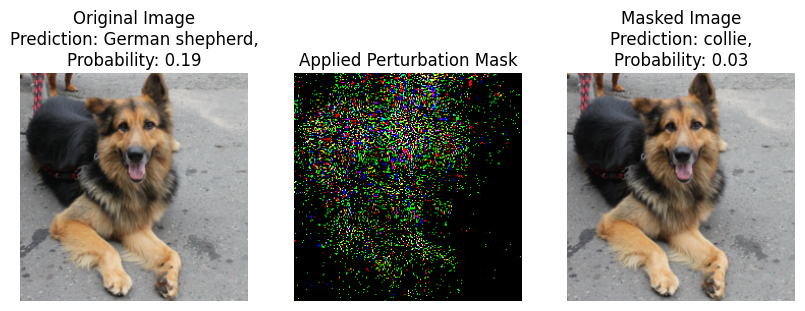

In [26]:
# provided code
# DO NOT CHANGE

with torch.no_grad():
    output = model(img_tensor)
    masked = model(img_tensor+mask_parameter)
    
    probs = torch.softmax(output, dim=1)[0][output[0].argmax()].item()
    mask_probs = torch.softmax(masked, dim=1)[0][masked[0].argmax()].item()

    prediction = labels[output[0].argmax()]
    mask_prediction = labels[masked[0].argmax()]

    unnormed_img_tensor= unnormalize(img_tensor)
    unnormed_mask_tensor= unnormalize(masked_img_tensor)

    img_pil = tensor_to_pil(img_tensor)
    masked_pil = tensor_to_pil(masked_img_tensor)
    
plt.figure(figsize=(10, 5))  # Adjust the figsize as needed
plt.subplot(1, 3, 1)
plt.imshow(img_pil)
plt.title(f"Original Image\nPrediction: {prediction},\nProbability: {probs:.2f}")
plt.axis('off')

mask_pil = transforms.functional.to_pil_image(mask_parameter[0])
plt.subplot(1, 3, 2)
plt.imshow(mask_pil)
plt.title(f"Applied Perturbation Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(masked_pil)
plt.title(f"Masked Image\nPrediction: {mask_prediction},\nProbability: {mask_probs:.2f}")
plt.axis('off')

plt.show()

Nice work. We know images can feel contrived, but it's still cool to see it in action! Let's see how far away these images are after our attack...

In [27]:
# DO NOT CHANGE
masked_img_tensor = img_tensor+mask_parameter

l2_norm = torch.norm(img_tensor - masked_img_tensor, p=2)
print("Distance (L2 norm) between original image and masked image:\n---------------\n", l2_norm.item())

Distance (L2 norm) between original image and masked image:
---------------
 0.96547931432724


Here's a chart that shows - for every pixel value, what's the difference between the first and second images. The important thing to note here is the `x-axis` - we'll look at a few of these. The larger to numbers along the `x-axis` the larger the changes to the image. 

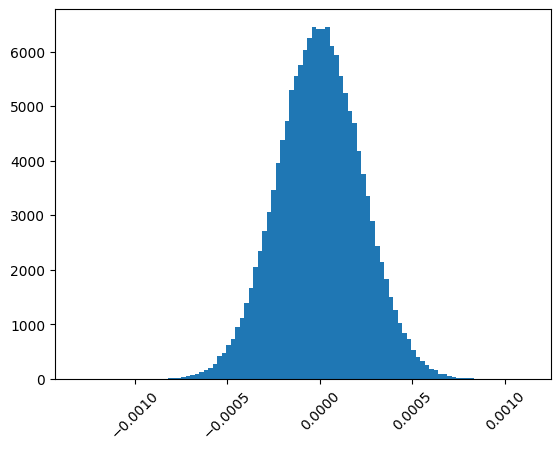

Minimum and maximum difference between the images: -0.0013089179992675781 0.0011256933212280273


In [28]:
# DO NOT CHANGE

difference = unnormed_mask_tensor - unnormed_img_tensor
difference_list = difference.view(-1).tolist()

# Plot the histogram
plt.hist(difference_list, bins=100)
plt.xticks(rotation=45)
plt.show()

print("Minimum and maximum difference between the images:", difference.min().item(), difference.max().item())

:::{exercise}

Okay. Here's the deal. These attacks are cool, but there are some very real operational constraints, primarily as it relates to lossy data conversions. Let's explore one of those now.

1. Save the adversarial image (`masked_pil`) as a `jpeg` (`masked_pil.save()`)
2. Reload it from disk, process it, and submit it to the model and examine the output
3. Repeat steps 2 and 3 but save your adversarial image as a `png` 
4. Can you explain what's going on?


Success criteria:
- Just complete the steps: most of the time, the jpg image should no longer be an effective evasion, while the png might still work (if they both work, then you got luck or unlucky depending on your point of view... try creating a new adversarial image?)


What we want you to get out of this:
- The results we get from evasions may not correspond to real-world images that can be saved to and loaded from a file -- you might have to do a bit more work to get something you can submit to a model API.  
  - Hint: look at the individual pixel values in your mask, and compare to the pixel values you get from the image version after you load it
- Lossy vs lossless image formats can (often) have an impact
- Start thinking about defenses: if saving it to a file and loading it can (sometimes) screw up the evasion, what else might defend against these evasions?

In [30]:
# your code here
masked_pil= tensor_to_pil(masked_img_tensor)
masked_pil.save(fp="output.jpg")

# load the same img

new_img = Image.open("output.jpg")

# Just evaluating

with torch.no_grad():
    jpg_img_array = preprocess(new_img).to(device).unsqueeze(0)
    outputs = model(jpg_img_array)[0].argmax()

print("Target index jpg is:", outputs)
print("Target label jpg is:", labels[outputs])

# repeat for PNG
masked_pil.save(fp='output.png')

new_img = Image.open("output.png")

with torch.no_grad():
    png_img_array = preprocess(new_img).to(device).unsqueeze(0)
    outputs = model(png_img_array)[0].argmax()

print("Target index png is:", outputs)
print("Target label png is:", labels[outputs])

Target index jpg is: tensor(235, device='cuda:0')
Target label jpg is: German shepherd
Target index png is: tensor(231, device='cuda:0')
Target label png is: collie


See the [answer key](answers-1_evasion-open-box.ipynb) notebook for the solutions to this exercise.

So we've seen an untargeted example: make the German Shepherd look like anything *but* a German Shepherd (according to the model). However, there are times when you may need to target a particular label or there are only two classes -- a binary classifier for example. Having only 2 classes is by default a targeted attack -- the thing you have is `class_0` and anything but `class_0` can _only_ be `class_1`. This can actually be quite a powerful primitive if you think about it. 

Though, we'll show you the "proper" way below.

### _Targeted_ Carlini and Wagner L2 Attack
If we want to target a specific class (say 513 -- corkscrew) the process is similar; the main difference is that rather than negating the loss for the 'real' class, we use 'normal' loss, _but for the wrong (target) class_. We're still trying to find a good 'mask' to make it work, but because the classes are so different, we're going to apply a 'weight' to the L2 norm component. Essentially this allows the distance to be a bit bigger, and hence the potential visual distortion to be larger. 

We'll reload the image, just so you can be sure we don't have anything up our sleeves.

#### Reload the Image

In [31]:
# DO NOT CHANGE

# define how much we want to change the image 
change = 1e-3

# create new img_tensor
img_tensor = preprocess(img).unsqueeze(0).to(device)

# create the halloween mask 
mask = torch.randn_like(img_tensor)*change

# create the mask parameter
mask_parameter = torch.nn.Parameter(mask.to(device))

optimizer = torch.optim.Adam([mask_parameter])
target_index = model(img_tensor).argmax()

print(f"Pred Index:\n---------------\n{output[0].argmax()}\n")
print(f"Pred Label:\n---------------\n{labels[output[0].argmax()]}\n")

Pred Index:
---------------
235

Pred Label:
---------------
German shepherd



#### Select a Target Class

Let's set the target class we want our attack to give us - we chose this randomly; you should experiment with different ones later.  Note that we make it into a tensor and move it to the correct device, as PyTorch will require to compute losses.

In [32]:
# DO NOT CHANGE

# 512 is the index of 'corkscrew`
target_index = torch.tensor(labels.index('corkscrew')).unsqueeze(0).to(device)
print("Target index is:\n---------------\n", target_index)

Target index is:
---------------
 tensor([512], device='cuda:0')


#### Redefine the Loss Function to Target a Specific Class

Next, we will add an `l2_weight` arguments to our `loss` function. Increasing the weight allows the optimization process to make bigger changes to the mask, which hopefully leads to the optimization process finding the targeted class. So here, instead of moving away from the original class using the negative classification loss, we want to _minimize_ toward the `target_index` of `corkscrew`.  

Take a look at the `l2_weight` parameter below and make sure you understand what's going on: we want to allow the perturbation to be larger, so the $L_2$ distance will need to be larger, so we downweight that component of the loss -- with `l2_weight = 0.5` we can have the $L_2$ distance be twice as large while still producing the same loss value (which we are trying to minimize).

In [33]:
# DO NOT CHANGE

def loss(output, mask, target_index, l2_weight):
    # Now we're removing the negative, we want it to be classified as the target_index
    classification_loss = torch.nn.functional.cross_entropy(output, target_index)
    
    # this says "No single pixel should be big, and the total magnitude of all of them should be small"
    l2_loss = torch.pow(mask, 2).sum()
    
    total_loss =  classification_loss+(l2_weight * l2_loss)
    
    # Now we penalize large distortions a bit less.
    return total_loss, classification_loss, l2_loss

#### Optimize

Then we run the attack as before and visualize. 

This should take well under 1000 steps; if steps goes past 1000, interrupt and try again, starting from the cell where you create the mask. 

In [34]:
# DO NOT CHANGE

import sys

l2_weight = 0.5
step = 0

while True: # evaluate it until the prediction matches the target label
    output = model(img_tensor+mask_parameter)
    total_loss, class_loss, l2_loss = loss(output, mask_parameter, target_index, l2_weight)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    step+=1
    
    sys.stdout.write(f"\rStep: {step}  total loss: {total_loss.item():4.4f}    class loss:{class_loss.item():4.4f}     l2 loss: {l2_loss.item():4.4f}   Predicted class index:{output[0].argmax()}");
    sys.stdout.flush()

    if output[0].argmax().item() == target_index.item():
        break
        
print(f"\n\nWinner winner: {labels[output[0].argmax()]}")

Step: 605  total loss: 5.0852    class loss:2.6856     l2 loss: 4.7990   Predicted class index:512

Winner winner: corkscrew


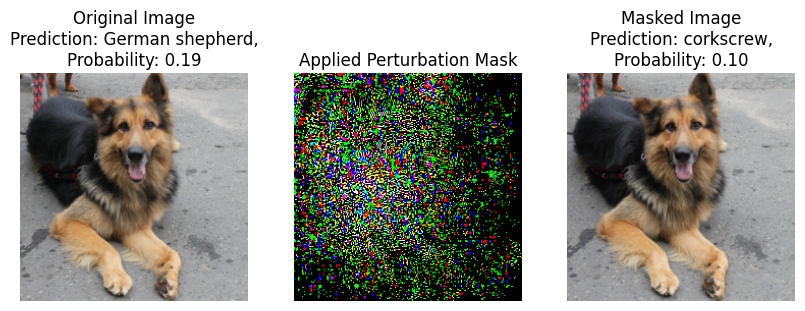

In [35]:
# DO NOT CHANGE

masked_img_tensor = img_tensor + mask_parameter

# get the model prediction and score for the original image and the masked image
with torch.no_grad():
    output = model(img_tensor)
    masked = model(masked_img_tensor)
    
    probs = torch.softmax(output, dim=1)[0][output[0].argmax()].item()
    mask_probs = torch.softmax(masked, dim=1)[0][masked[0].argmax()].item()

    prediction = labels[output[0].argmax()]
    mask_prediction = labels[masked[0].argmax()]

    img_pil = tensor_to_pil(img_tensor)
    masked_pil = tensor_to_pil(masked_img_tensor)
    
plt.figure(figsize=(10, 5))  # Adjust the figsize as needed
plt.subplot(1, 3, 1)
plt.imshow(img_pil)
plt.title(f"Original Image\nPrediction: {prediction},\nProbability: {probs:.2f}")
plt.axis('off')

mask_pil = transforms.functional.to_pil_image(mask_parameter[0])
plt.subplot(1, 3, 2)
plt.imshow(mask_pil)
plt.title(f"Applied Perturbation Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(masked_pil)
plt.title(f"Masked Image\nPrediction: {mask_prediction},\nProbability: {mask_probs:.2f}")
plt.axis('off')

plt.show()

If you look at the two images, you probably will notice that they look slightly different; however both look like dogs, despite the model thinking that one is a corkscrew.

In [36]:
# DO NOT CHANGE

l2_norm = torch.norm(img_tensor - masked_img_tensor, p=2)
print("Distance (L2 norm) between original image and masked image:\n---------------\n", l2_norm.item())

Distance (L2 norm) between original image and masked image:
---------------
 2.277338981628418


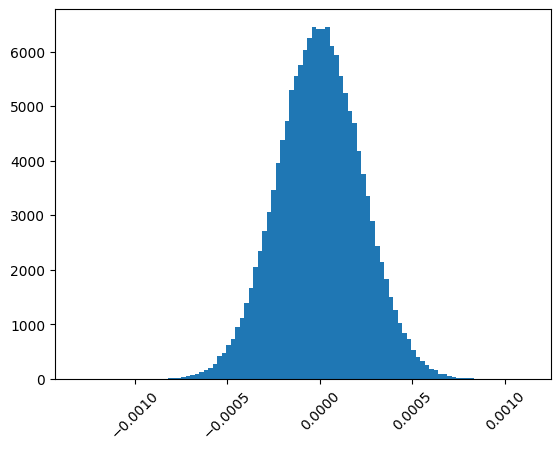

Minimum and maximum difference between the images: -0.0013089179992675781 0.0011256933212280273


In [37]:
# DO NOT CHANGE

difference = unnormed_mask_tensor - unnormed_img_tensor
difference_list = difference.view(-1).tolist()

# Plot the histogram
plt.hist(difference_list, bins=100)
plt.xticks(rotation=45)
plt.show()

print("Minimum and maximum difference between the images:", difference.min().item(), difference.max().item())

:::{exercise}

What do you notice about the distance between the original image and the adversarial image relative to the output score?

What do you notice about the distribution of differences between the original and adversarial images for the two evasive approaches (targeted and untargeted)?  (Range and shape)


What we want you to get out of this exercise:
- Notice that different techniques leave different 'signatures' in the adversarial image
:::

# Conclusion 
Okay, now you should have a good understanding of the math and process underlying inversion attacks. But what happens when you don't have full access to the gradients? Move to the next module for closed box attacks.

## What You Learned

1. The concept of evasion with random perturbations.
2. More nuanced attacks to understand efficiency and tradecraft.
3. The differences between _targeted_ and _untargeted_ evasion.
4. How to optimize attacks.

**Move on to the [next lab](../2_evasion/2_evasion-closed-box.ipynb)**.

![DLI Logo](../assets/DLI_Header.png)